# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Lab 5:  Feed Forward Neural Networks 2 (Training, Evaluation, & Interogation)

**Harvard University**<br/>
**Spring 2022**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas<br/>
**Lab Team**: Eleni Kaxiras, Marios Mattheakis, Chris Gumb, Shivas Jayaram
<br/>

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### Table of Contents
- Building a NN /w Keras Quick Review
- Learning weights from Data
- Evaluating a Keras Model
- Inspecting Training History
- Multi-class Classification Example (Tabular Data)
- Interpreting Our Black Box NN
- Bagging Review
- Image Classification Example

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Let's revisit the toy dataset from the first NN lab.

In [3]:
# Load toy data
toydata = pd.read_csv('data/toyDataSet_1.csv')
x_toy = toydata['x'].values.reshape(-1,1)
y_toy = toydata['y'].values.reshape(-1,1)

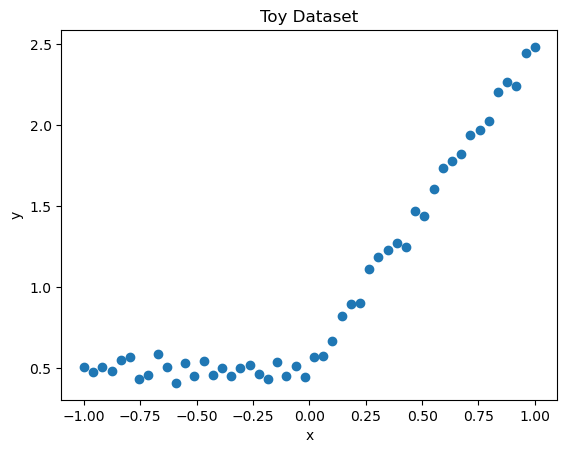

In [4]:
# Plot toy data
ax = plt.gca()
ax.scatter(x_toy, y_toy)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Toy Dataset');

In [5]:
from tensorflow.keras import models, layers, activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input # Input "layer"?!?

2023-07-31 15:51:58.772687: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-31 15:51:58.798008: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-31 15:51:58.798487: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 15:51:59.423721: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Here we construct a sequential Keras model with one Dense hidden layer containing only a single neuron with a relu activation.\
The output layer will be of size 1 and have no activation (e.g., 'linear').

In [6]:
# Instantiate sequential Keras model and give it a name
toy_model = Sequential(name='toy_model')

# Despite designation in Keras, Input is not a true layer
# It only specifies the shape of the input
toy_model.add(Input(shape=(1,)))
              
# hidden layer with 1 neurons (or nodes)
toy_model.add(Dense(1, activation='relu'))

# output layer, one neuron 
toy_model.add(Dense(1,  activation='linear'))

toy_model.summary()

Model: "toy_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 4 (16.00 Byte)
Trainable params: 4 (16.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-07-31 15:52:00.093300: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


<div class='exercise'> <b>Compiling the NN</div>

    


`model.compile(optimizer, loss, metrics, **kwargs)`

`optimizer` - defines how the weights are updated (we'll use SGD)\
`loss` - what the model is trying to minimize\
`metric` - list of metrics to report during training process

`compile` is used to configure a NN model be for it can be fit. We aren't ready to fit *just* yet, but we are compiling here because doing so reinitilizes the model weights. We are going to manually set our weights before training so we need to to the compilation first.

**Q:** Why do I want metrics if I already have a loss?

In [7]:
import tensorflow as tf
from tensorflow.keras import optimizers, losses, metrics
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import mse

In [8]:
toy_model.compile(optimizer=SGD(learning_rate=1e-1), loss='mse', metrics=[])

<div class='exercise'> <b>A little nudge...</div>

    


Our toy model is very simply. It only has 4 weights. But the problem there are only 4 possible weight values that would make this a good fit. That is like finding a needle in a haystack. So we will cheat a bit and initialize our weights in the 'neighborhood' of the true weights which generated the data. Our future models will be complex enough that they won't need to worry about finding a specific combination of weights: some local minima (but not all) will do the job just fine.

In [9]:
# A FUNCTION THAT READS AND PRINTS OUT THE MODEL WEIGHTS/BIASES
def print_weights(model):
    weights = model.get_weights()
    print(dict(zip(["w1", "b1", "w2", "b2"], [weight.flatten()[0] for weight in weights])))

# MANUALLY SETTING THE WEIGHTS/BIASES
## True weights from data generating function
# w1 = 2
# b1 = 0.0
# w2  = 1
# b2  = 0.5

# Initialize weights to that 'neighborhood'
w1 = 1.85
b1 = -0.5
w2  = 0.9
b2  = 0.4

# Store current weight data structure
weights = toy_model.get_weights()
# hidden layer
weights[0][0] = np.array([w1]) #weights 
weights[1]    = np.array([b1]) # biases
# output layer 
weights[2]    =  np.array([[w2]]) # weights
weights[3]    = np.array([b2])    # bias
# hidden layer
# Set the weights
toy_model.set_weights(weights)


print('Manually Initialized Weights:')
print_weights(toy_model)

Manually Initialized Weights:
{'w1': 1.85, 'b1': -0.5, 'w2': 0.9, 'b2': 0.4}


<div class='exercise'> <b>Forward Pass Review</b></div>

    


**Input, Hidden Layers, and Output Layers**

The **forward** pass through an FFNN  is  a sequence of linear (affine) and nonlinear operations (activation). 


<img src="fig/forward.jpg" width="70%"/>

We use the model's `predict` method to execut the forward pass with a linspace spanning the range of the `x` data as input.

16/16 [==============================] - 0s 536us/step


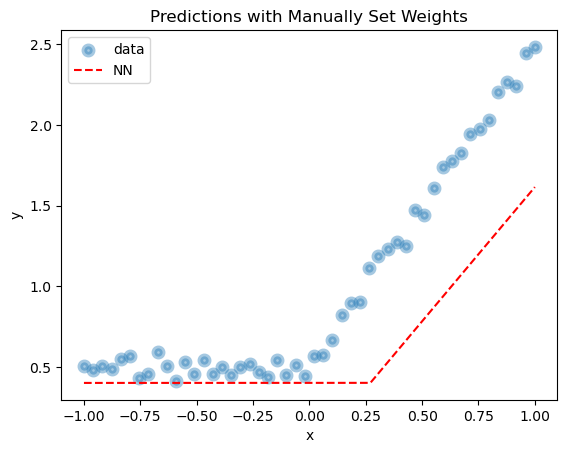

In [10]:
# Predict
x_lin = np.linspace(x_toy.min(), x_toy.max(), 500)
y_hat = toy_model.predict(x_lin)

# Plot
plt.scatter(x_toy, y_toy, alpha=0.4, lw=4, label='data')
plt.plot(x_lin, y_hat, label='NN', ls='--', c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Predictions with Manually Set Weights')
plt.legend();

We'll let back propogation and stochastic gradient descent take it from here.

<div class='exercise'> <b>Back Propogation & SGD Review</b></div>

    


The **backward** pass is the training. It is based on the chain rule of calculus, and it calculates the gradient of the loss w.r.t. the weights. This gradient is used by the optimizer to update the weights to minimize the loss function.

<img src="fig/dl.jpg" width="70%"/>

**Batching, stochastic gradient descent, and epochs**
Shuffle and partition the dataset in mini-batches to help escape from local minima. Each batch is seen once per epoch. And thus each observation is also seen once per epoch. We can train the network for as many epochs as we like.

<img src="fig/batching.jpg" width="70%"/>

<div class='exercise'> <b>Reproducibility</b></div>    


There is a lot of stochasticity in the training of neural networks, from weight initilizations, to shuffling of data between epochs.\
Below is some code that appears to be working for me to get reproducible results. Though I think some of the steps taken may be purely superstitious.

In [11]:
# Advice gleaned from: https://deeplizard.com/learn/video/HcW0DeWRggs
import os
import random as rn

os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
tf.random.set_seed(109)
np.random.seed(109)
rn.seed(109)

<div class='exercise'> <b>Fitting the NN</div>    

`Model.fit(x=None, y=None, batch_size=None, epochs=1, verbose="auto", validation_split=0.0, validation_data=None, shuffle=True, **kwargs)`

`batch_size` - number of observations overwhich the loss is calculated before each weight update\
`epochs` - number of times the complete dataset is seen in the fitting process\
`verbose` - you can silence the training output by setting this to `0`\
`validation_split` - splits off a portion of the `x` and `y` training data to be used as validation (see warning below)\
`validation_data` - tuple designating a seperate `x_val` and `y_val` dataset\
`shuffle` - whether to shuffle the training data before each epoch

We fit the model for 100 `epochs` and set `batch_size` to 64. The results of `fit()` are then stored in a variable called `history`.  

In [12]:
# Fit model and store training histry
history = toy_model.fit(x_toy, y_toy, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
1/1 [==============================] - 0s 188ms/step - loss: 0.2432
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1465
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0889
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0558
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0375
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0271
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0213
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 13/100
1/1 [==============================] - 0s 2ms/

<div class='exercise'> <b>Plot Training History</div>

`history.history` is a dictionary which contains information from each training epoch (no, I don't know the rationale behind the double name). Use it to plot the loss across epochs. Don't for get those labels!

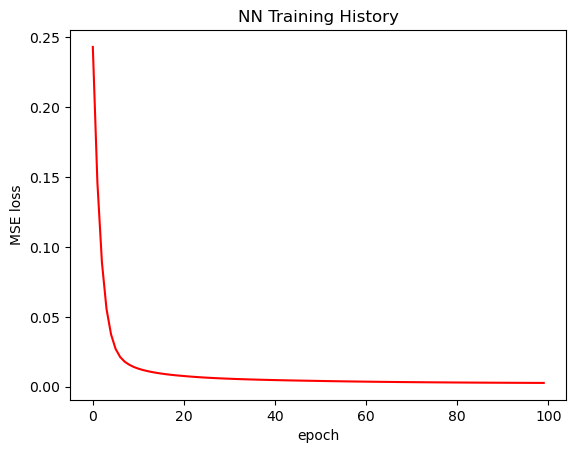

In [13]:
# Plot training history
plt.plot(history.history['loss'], c='r')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.title('NN Training History');

In [14]:
# Weights learned for the data
print_weights(toy_model)

{'w1': 1.987246, 'b1': -0.051335987, 'w2': 1.0406225, 'b2': 0.5044429}


We can see we've moved much closer to the original weights after fitting.

But visualizing our model's predictions will make this more clear.

<div class='exercise'> <b>Predict & Plot</div>

We use the model's `predict` method on a linspace, `x_lin`, which we construct to span the range of the dataset's $x$ values. We save the resulting predictions in `y_hat`

16/16 [==============================] - 0s 480us/step


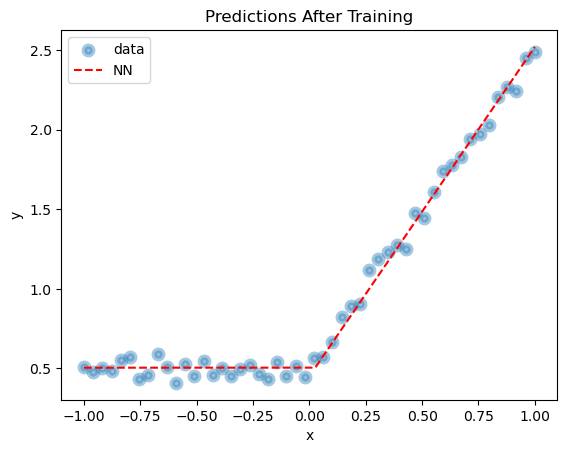

In [15]:
# Predict
x_lin = np.linspace(x_toy.min(), x_toy.max(), 500)
y_hat = toy_model.predict(x_lin)

# Plot
plt.scatter(x_toy, y_toy, alpha=0.4, lw=4, label='data')
plt.plot(x_lin, y_hat, label='NN', ls='--', c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Predictions After Training')
plt.legend();

Much better! But perhaps you are not impressed yet?

<div class='exercise'> <b>An Ugly Function</div>
    

In [16]:
def ugly_function(x):
    if x < 0:
        return np.exp(-(x**2))/2 + 1 + np.exp(-((10*x)**2))
    else:
        return np.exp(-(x**2)) + np.exp(-((10*x)**2))

How do you feel about the prospect of manually setting the weights to approximate this beauty?

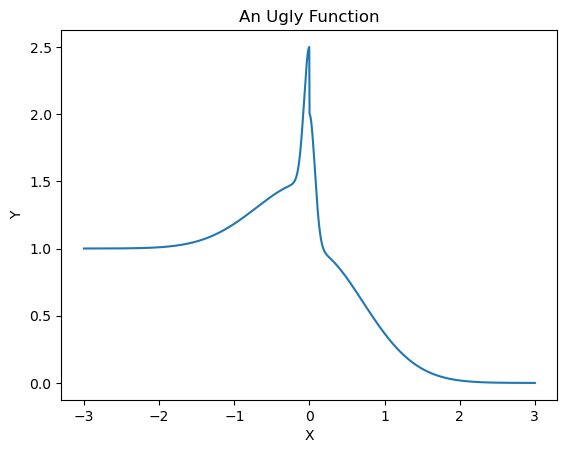

In [17]:
# Generate data
x_ugly = np.linspace(-3,3,1500) # create x-values for input
y_ugly = np.array(list(map(ugly_function, x_ugly)))

# Plot data
plt.plot(x_ugly, y_ugly);
plt.title('An Ugly Function')
plt.xlabel('X')
plt.ylabel('Y');

And here we don't even have the option of cheating by initializing our weights strategically!

<div class="alert alert-success">
    <strong>🏋🏻‍♂️ TEAM ACTIVITY:</strong> We're Gonna Need a Bigger Model...</div>  

1. Complete the `build_nn` function for quickly constructing different NN architectures.
    
2. Use `build_nn` to construct an NN to approximate the ugly function
    
3. Compile the model & print its summary
    -  _Tip: Remember, if it is the last line of the cell, Jupyter will display the return value without an explicit call to `print()` required. In fact, Jupyter uses its own `display()` function which often results in prettier output for tables_
4. Fit the model

5. Plot the training history
    
Hyperparameters to play with:
- Architecture
    - Number of hidden layers
    - Number of neurons in each hidden layer
    - Hidden layers' `activation` function
- Training
    - `SGD`'s `learning_rate`
    - `batch_size`
    - `epochs`


**NN Build Function**\
**Arguments:**
- `name`: str - A name for your NN.
- `input_shape`: tuple - number of predictors in input (remember the trailing ','!)
- `hidden_dims`: list of int - specifies the number of neurons in each hidden layer
    - Ex: [2,4,8] would mean 3 hidden layers with 2, 4, and 8 neurons respectively
- `hidden_act`: str (or Keras activation object) - activation function used by all hidden layers
- `out_dim`: int - number of output neurons a.k.a 'ouput units'
- `out_act`: str (or Keras activation object) - activation function used by output layer

**Hint:** We will reuse this function throughout the notebook in different settings, but you should go ahead and set some sensible defaults for *all* of the arguments.

In [18]:
# your code here
def build_NN(name='NN', input_shape=(1,), hidden_dims=[2], hidden_act='relu', out_dim=1, out_act='linear'):
    model = Sequential(name=name)
    model.add(Input(shape=input_shape))
    for hidden_dim in hidden_dims:
        model.add(Dense(hidden_dim, activation=hidden_act))
    model.add(Dense(out_dim, activation=out_act))
    return model

In [19]:
# %load ../solutions/sol1_1.py
def build_NN(name='NN', input_shape=(1,), hidden_dims=[2], hidden_act='relu', out_dim=1, out_act='linear'):
    model = Sequential(name=name)
    model.add(Input(shape=input_shape))
    for hidden_dim in hidden_dims:
        model.add(Dense(hidden_dim, activation=hidden_act))
    model.add(Dense(out_dim, activation=out_act))
    return model

**Build & Print Model Summary**

You can play with `hidden_dims` and `hidden_act`.

In [20]:
# your code here
ugly_model = build_NN(name='ugly', hidden_dims=[64, 32, 16, 8])
ugly_model.summary()

Model: "ugly"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2881 (11.25 KB)
Trainable params: 2881 (11.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Compile**\
Use the `SGD` optimizer and `'mse'` as your loss.\
You can expermiment with `SGD`'s `learning_rate`.

In [21]:
# Compile
# your code here
ugly_model.compile(optimizer=SGD(learning_rate=1e-1), loss='mse')

**Fit**\
Fit `ugly_model` on `x_ugly` and `y_ugly` and story the results in a variable called `history`.\
You can experiment with `epochs` and `batch_size`.

In [22]:
# Fit
# your code here
history = ugly_model.fit(x_ugly, y_ugly, epochs=100, batch_size=32)

Epoch 1/100
47/47 [==============================] - 0s 601us/step - loss: 0.1103
Epoch 2/100
47/47 [==============================] - 0s 585us/step - loss: 0.0453
Epoch 3/100
47/47 [==============================] - 0s 564us/step - loss: 0.0253
Epoch 4/100
47/47 [==============================] - 0s 560us/step - loss: 0.0137
Epoch 5/100
47/47 [==============================] - 0s 566us/step - loss: 0.0114
Epoch 6/100
47/47 [==============================] - 0s 573us/step - loss: 0.0105
Epoch 7/100
47/47 [==============================] - 0s 585us/step - loss: 0.0101
Epoch 8/100
47/47 [==============================] - 0s 584us/step - loss: 0.0096
Epoch 9/100
47/47 [==============================] - 0s 572us/step - loss: 0.0087
Epoch 10/100
47/47 [==============================] - 0s 575us/step - loss: 0.0084
Epoch 11/100
47/47 [==============================] - 0s 538us/step - loss: 0.0075
Epoch 12/100
47/47 [==============================] - 0s 718us/step - loss: 0.0090
Epoch 13/100


**Plot Training History**

Plot the model's training history. Don't forget your axis labels!\
**Hint:** Remember, `fit` returns a `history` object which itself has a `history` dictionary attribute. Because this (2nd object) is a dictionary, you can always use its `keys`method if you don't know what's in it. You can also access the history from the model itself. Ex: `ugly_model.history.history`

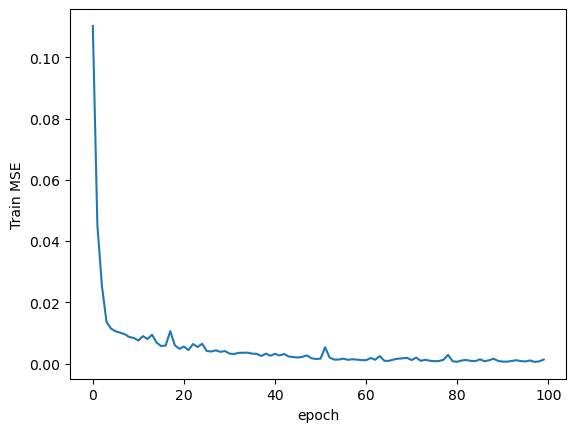

In [23]:
# Plot History
# your code here
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('Train MSE');

**Get Predictions**\
Similar to `sklearn` models, `keras` models have a `predict` method. Use your model's `predict` method to predict on `x_ugly` and store the results in a variable called `y_hat_ugly`.

In [24]:
# Predict
y_hat_ugly = ugly_model.predict(x_ugly)

47/47 [==============================] - 0s 509us/step


**Plot Predictions**\
Run the cell below to compare your model's predictions to the true (ugly) function. Still not quite right? Try tweaking some of the hyperparameters above and re-run the cells in this section to see if you can improve.

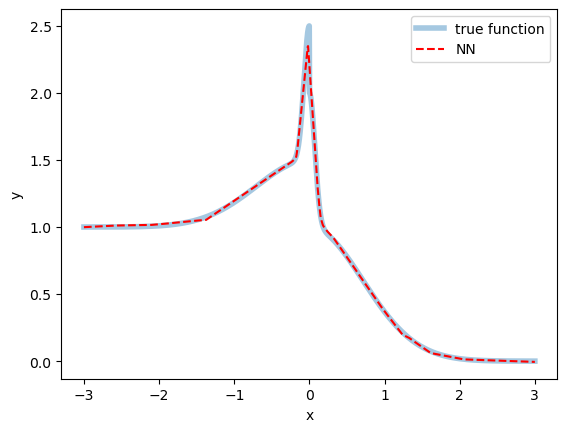

In [25]:
# Plot predictions
plt.plot(x_ugly, y_ugly, alpha=0.4, lw=4, label='true function')
plt.plot(x_ugly, y_hat_ugly, label='NN', ls='--', c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.legend();

**End of Team Activity**

<div class='exercise'> <b>Multi-class Classification with Keras</div>


In [26]:
import seaborn as sns

So far we've only used our new Keras powers for toy regression problems. We'll move to classification next... but with 3 classes!

This example will use `seaborn`'s penguins dataset (a worthy successor to the connonical iris dataset.)

We'll build a model to identify a penguin's species from its other features. In the process we'll dust off our Python skills with a quick run through a basic model building workflow.

In [27]:
# Bring on the penguins!
penguins = sns.load_dataset('penguins')
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


We have 3 species of penguins living across 3 different islands. There are measurements of bill length, bill depth, flipper length, and body mass. We also have categorcial variable for each penguin's sex giving us a total of 7 features.

Here's a plot that tries to show too much at once. But you can ignore the marker shapes and sizes. The bill and flipper length alone ($x$ and $y$ axes) seem too already provide a fair amount of information about the species (color).

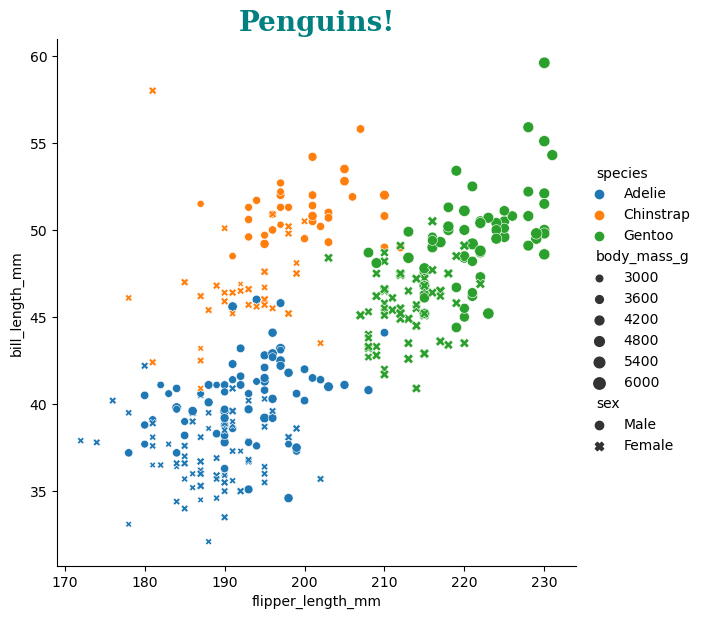

In [28]:
# Plot penguins with too much info
sns.relplot(data=penguins, x='flipper_length_mm', y='bill_length_mm',
            hue='species', style='sex', size='body_mass_g', height=6);
plt.title('Penguins!', fontdict={'color': 'teal', 'size': 20, 'weight': 'bold', 'family': 'serif'});

You may have noticed some pesky `NaN`s when we displayed the beginning of the DataFrame.\
We should investigate further.

<div class='exercise'> <b>Missingness</div>


In [29]:
# How many missing values in each column?
penguins.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

Let's take a look at them first all the rows with missing data.

In [30]:
# Rows with missingness
penguins[penguins.isna().any(axis=1)]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN


Yikes! There are two observations where all predictors except `species` and `island` are missing.\
These rows won't be of any use to us. We see that dropping rows missing `body_mass_g` will take care of most our missingness.

In [31]:
# Drop the bad rows identified above
penguins = penguins.dropna(subset=['body_mass_g'])
# Check state of missingness after dropping
penguins.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  9
dtype: int64

It looks like there are 9 rows where `sex` is missing. We can try to **impute** these values.\
But first, take a look at our DataFrame again.

In [32]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


Notice how the indices go from `2` to `4`. What happened to `3`?\
It was one of the rows we dropped! This issue with the indices can cause headaches later on (think `loc`/`iloc` distinction).
But we can make things good as new using the `reset_index` method. Just be sure to set `drop=True`, otherwise the old indices will be added to the DataFrame as a new column.

In [33]:
# Reset index
penguins = penguins.reset_index(drop=True)
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


Much better!\
Now, on to imputing the missing `sex` values. Let's take a look at the `value_counts`.

In [34]:
# Counts of each unique value in the dataset
penguins.sex.value_counts()

Male      168
Female    165
Name: sex, dtype: int64

It's almost an even split. We'll impute the **mode** because it's a quick fix.

In [35]:
# The mode here should match the value with the most counts above
sex_mode = penguins.sex.mode()[0]
sex_mode

'Male'

Finally, we use `fillna` to replace the remaining `NaN`s with the `sex_mode` and confirm that there are no more missing values in the DataFrame.

In [36]:
# Replace missing values with most common value (i.e, mode)
penguins = penguins.fillna(sex_mode)
penguins.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

**Q:** Imputing the mode here was very easy, but does this approach make you a bit nervous? Why? Is there some other way we could have imputed this values?

<div class='exercise'> <b>Preprocessing</div>

We can't just throw this DataFrame at a neural network as it is. There's some work we need to do first.

**Separate predictors from response variable**

In [37]:
# Isolate response from predictors
response = 'species'
X = penguins.drop(response, axis=1)
y = penguins[response]

**Encode Categorical Predictor Variables**

In [38]:
# Check the predictor data types
X.dtypes

island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

Both `island` and `sex` are categotical. We can use `pd.get_dummies` to one-hot-encode them (don't forget to `drop_first`!).

In [39]:
# Identify the categorical columns
cat_cols = ['island', 'sex']

In [40]:
# one-hot encode the categorical columns
X_design = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X_design.head(1)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_Male
0,39.1,18.7,181.0,3750.0,0,1,1


From the remaining columns we can infer that the 'reference' values for our categorical variables are `island = 'Biscoe'`, and `sex = 'Female'`.

**Feature Scaling**

We should take a closer look at the range of values our predictors take on.

In [41]:
#  Summary stats of predictors
X_design.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_Male
count,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386,0.362573,0.149123,0.517544
std,5.459584,1.974793,14.061714,801.954536,0.481447,0.356731,0.500424
min,32.100000,13.100000,172.000000,2700.000000,0.000000,0.000000,0.000000
25%,39.225000,15.600000,190.000000,3550.000000,0.000000,0.000000,0.000000
50%,44.450000,17.300000,197.000000,4050.000000,0.000000,0.000000,1.000000
75%,48.500000,18.700000,213.000000,4750.000000,1.000000,0.000000,1.000000
max,59.600000,21.500000,231.000000,6300.000000,1.000000,1.000000,1.000000


Our features are not on the same scale. Just compare the min/max of `bill_depth_mm` and `body_mass_g` for example.\
This can slow down neural network training for reasons we'll see in an upcoming lecture.

Let's make use of `sklearn`'s `StandardScaler` to standardize the data, centering each predictor at 0 and setting their standard deviations to 1.

In [42]:
from sklearn.preprocessing import StandardScaler

In [43]:
# Remember the column names for later; we'll lose them when we scale
X_cols = X_design.columns
# Saving the scaler object in a variable allows us to reverse the transformation later
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_design)

In [44]:
# The scaler was passed a pandas DataFrame but returns a numpy array
type(X_scaled), X_scaled.shape

(numpy.ndarray, (342, 7))

In [45]:
# We can always add the column names back later if we need to
pd.DataFrame(X_scaled, columns=X_cols).head(3)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_Male
0,-0.884499,0.785449,-1.418347,-0.564142,-0.754193,2.388699,0.965507
1,-0.811126,0.126188,-1.062250,-0.501703,-0.754193,2.388699,-1.035725
2,-0.664380,0.430462,-0.421277,-1.188532,-0.754193,2.388699,-1.035725


**Encoding the Response Variable**

In [46]:
# Take a look at our response
y

0      Adelie
1      Adelie
2      Adelie
3      Adelie
4      Adelie
        ...  
337    Gentoo
338    Gentoo
339    Gentoo
340    Gentoo
341    Gentoo
Name: species, Length: 342, dtype: object

Our response variable is still a `string`. We need to turn it into some numerical representation for our neural network.\
We could to this ourselves with a few list comprehensions, but `sklearn`'s `LabelEncoder` makes this very easy.

In [47]:
from sklearn.preprocessing import LabelEncoder

In [48]:
# Encode string labels as integers
# LabelEncoder uses the familar fit/transform methods we saw with StandardScaler
labenc = LabelEncoder().fit(y)
y_enc = labenc.transform(y)
y_enc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [49]:
# We can recover the class labels from the encoder object later
labenc.classes_

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

This gets us part of the way there. But the penguin species are **categorical** not **ordinal**. Keeping the labels as integers implies that species `2` is twice as "different" from species `1` as it is from species `0`. We want to perform a conversion here similar to the one-hot encoding above, except will will not 'drop' one of the values. This is where Keras's `to_categorical` utility function comes in.

In [50]:
from tensorflow.keras.utils import to_categorical

In [51]:
y_cat = to_categorical(y_enc)
y_cat

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

Perfect!

**Q:** If this is what our array of response variables looks like, what will this mean for the output layer of our neural network?

**Train-test Split**

In [52]:
from sklearn.model_selection import train_test_split

You may be familiar with using `train_test_split` to split the `X` and `y` arrays themselves. But here we will using it to create a set of train and test *indices*.

We'll see later that being able to determine which rows in the original `X` and `y` ended up in train or test will be helpful.

**Q:** But couldn't we just sample integers to get random indices? Why use `train_test_split`?

**A:** Because `train_test_split` allows for **stratified** splitting!

Here we use a trick to stratify on both the `sex` and `island` variables by concatinating their values together. This gives us a total of 6 possible values (2 sexs x 3 islands). By stratifying on this column we help ensure that each of the 6 possible sex/island combinations is equally represented in both train and test.

In [53]:
# Concatenate categorical columns; use this for stratified splitting
strat_col = penguins['sex'].astype('str') + penguins['island'].astype('str')
strat_col

0        MaleTorgersen
1      FemaleTorgersen
2      FemaleTorgersen
3      FemaleTorgersen
4        MaleTorgersen
            ...       
337       FemaleBiscoe
338       FemaleBiscoe
339         MaleBiscoe
340       FemaleBiscoe
341         MaleBiscoe
Length: 342, dtype: object

In [54]:
# Create train/test indices
train_idx, test_idx = train_test_split(np.arange(X_scaled.shape[0]),
                                                  test_size=0.5,
                                                  random_state=109,
                                                  stratify=strat_col)

In [55]:
# Index into X_scaled and y_cat to create the train and test sets
X_train = X_scaled[train_idx]
y_train = y_cat[train_idx]
X_test = X_scaled[test_idx]
y_test = y_cat[test_idx]

In [56]:
# Sanity check on the resulting shapes
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((171, 7), (171, 3), (171, 7), (171, 3))

**Validation Split**

Here is where those indices we saved come in handy.\
We also want to also ensure equal representation across train and validation.

In [57]:
# Subset original stratify column using saved train split indices
strat_col2 = strat_col.iloc[train_idx]
strat_col2.shape

(171,)

In [58]:
# Create train and validation splits from original train split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.5,
                                                    random_state=109,
                                                    stratify=strat_col2)

<div class="alert alert-success">
    <strong>🏋🏻‍♂️ TEAM ACTIVITY:</strong> Classify Those Penguins!</div>  

In [59]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import Accuracy, AUC
from tensorflow.keras.activations import softmax

**Build**

Construct your NN penguin classifier. You can make use of your `build_NN` function from earlier. What output activation should you use?

**Hint:** try to programaticlaly determin the input and output shape from your data rather than hard coding those values.

In [60]:
# Construct your NN and print the model summary
# your code here
model = build_NN(name='penguins',
                 input_shape=(X_train.shape[1],),
                 hidden_dims=[8,16,3],
                 hidden_act='relu',
                 out_dim=y_train.shape[1],
                 out_act='softmax')
model.summary()

Model: "penguins"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 8)                 64        
                                                                 
 dense_8 (Dense)             (None, 16)                144       
                                                                 
 dense_9 (Dense)             (None, 3)                 51        
                                                                 
 dense_10 (Dense)            (None, 3)                 12        
                                                                 
Total params: 271 (1.06 KB)
Trainable params: 271 (1.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
# %load solutions/sol2_1.py

**Compile**

Again, let's use `SGD` as our optimizer. You can fiddle with the `learning_rate`.\
What loss and metric(s) do you think are appropriate?

In [62]:
# Compile
# youre code here
model.compile(optimizer=SGD(learning_rate=1e-1),
              loss='categorical_crossentropy',
              metrics=['acc', 'AUC'])

**Fit**

Fit your model and store the results in a variable called `history`.\
Feel free to play with `batch_size` and `epochs`.

Don't forget to include the `validation_data`!

In [63]:
# Fit
# your code here
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    batch_size=64,
                    epochs=50)

Epoch 1/50
2/2 [==============================] - 0s 163ms/step - loss: 1.1481 - acc: 0.1294 - auc: 0.3433 - val_loss: 1.1396 - val_acc: 0.2442 - val_auc: 0.3578
Epoch 2/50
2/2 [==============================] - 0s 22ms/step - loss: 1.1096 - acc: 0.2706 - auc: 0.4662 - val_loss: 1.1189 - val_acc: 0.3372 - val_auc: 0.4078
Epoch 3/50
2/2 [==============================] - 0s 23ms/step - loss: 1.0816 - acc: 0.4000 - auc: 0.5274 - val_loss: 1.1023 - val_acc: 0.3837 - val_auc: 0.4973
Epoch 4/50
2/2 [==============================] - 0s 24ms/step - loss: 1.0536 - acc: 0.4588 - auc: 0.6180 - val_loss: 1.0889 - val_acc: 0.3605 - val_auc: 0.5427
Epoch 5/50
2/2 [==============================] - 0s 23ms/step - loss: 1.0302 - acc: 0.4824 - auc: 0.6570 - val_loss: 1.0790 - val_acc: 0.3488 - val_auc: 0.5489
Epoch 6/50
2/2 [==============================] - 0s 22ms/step - loss: 1.0135 - acc: 0.4824 - auc: 0.6671 - val_loss: 1.0734 - val_acc: 0.3488 - val_auc: 0.5539
Epoch 7/50
2/2 [=================

**Plot**

Finally, write some code to visualize your loss and metric(s) across the training epochs. You should include both **train** and **validation** scores. This is where a **legend** is very important!

**Note:** If you load the solutions they may not run for you unless you have selected the same metric(s)

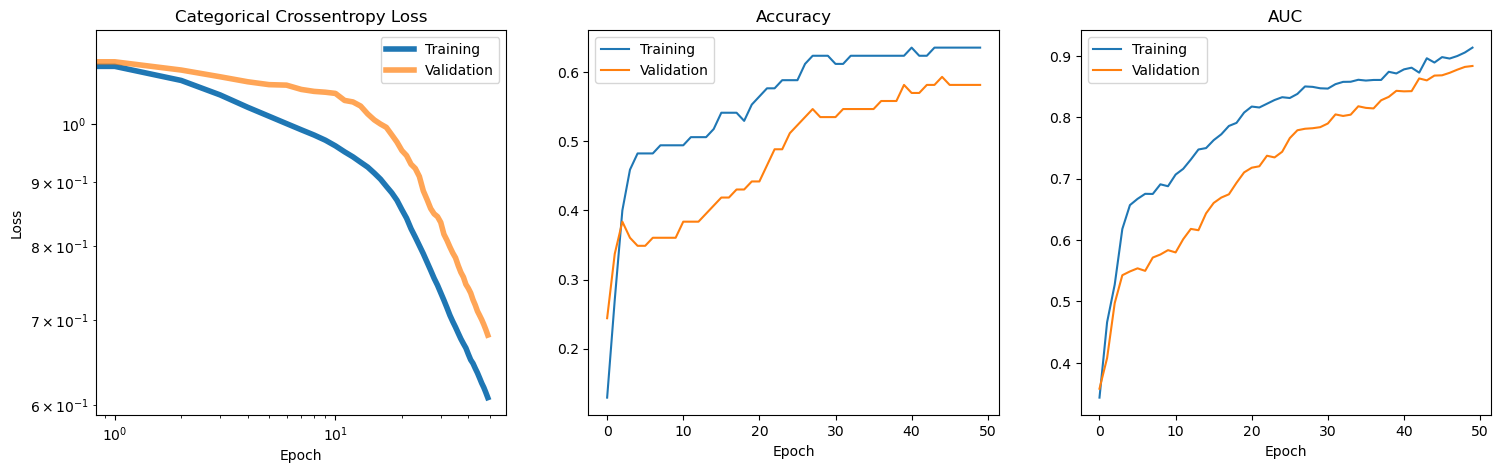

In [64]:
# Plot training history
# your code here
fig, axs = plt.subplots(1,3, figsize=(18,5))
                       
axs[0].loglog(history.history['loss'],linewidth=4, label = 'Training')
axs[0].loglog(history.history['val_loss'],linewidth=4, label = 'Validation', alpha=0.7)
axs[0].set_ylabel('Loss')


axs[1].plot(history.history['acc'], label='Training')
axs[1].plot(history.history['val_acc'], label='Validation')

axs[2].plot(history.history['auc'], label='Training')
axs[2].plot(history.history['val_auc'], label='Validation')

titles = ['Categorical Crossentropy Loss', 'Accuracy', 'AUC']
for ax, title in zip(axs, titles):
    ax.set_xlabel('Epoch')
    ax.set_title(title)
    ax.legend()

In [65]:
#%load solutions/sol2_2.py

**End of Team Activity**

<div class='exercise'> <b>Evaluating the Model</div>


First, let's see how well we could to by simply predicting the majority class in the training data for all observations.

In [66]:
naive_acc = y_train.mean(axis=0).max()
print('Naive Accuracy:', naive_acc)

Naive Accuracy: 0.4


In [67]:
# Train
model.evaluate(X_train, y_train)

3/3 [==============================] - 0s 2ms/step - loss: 0.6026 - acc: 0.6353 - auc: 0.9159


[0.6025658249855042, 0.6352941393852234, 0.9158823490142822]

In [68]:
# Validation
model.evaluate(X_val, y_val)

3/3 [==============================] - 0s 2ms/step - loss: 0.6810 - acc: 0.5814 - auc: 0.8837


[0.6810425519943237, 0.5813953280448914, 0.8836532831192017]

In [69]:
# Test
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 1ms/step - loss: 0.6439 - acc: 0.6374 - auc: 0.9082


[0.6438831090927124, 0.6374269127845764, 0.9081854224205017]

<div class='exercise'> <b>Black Box Interpretation</div>


**Proxy Model**

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, GridSearchCV

In [71]:
# Create train & test response variables for proxy model
y_train_bb = model.predict(X_train).argmax(-1)
y_test_bb = model.predict(X_test).argmax(-1)

6/6 [==============================] - 0s 619us/step


In [72]:
# Use cross-validation to tune proxy's hyperparameters
parameters = {'max_depth':range(1,10),
              'criterion': ['gini', 'entropy']}

clf = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(clf, parameters, cv=5)

# fit using same train but NN's predictions as response
grid.fit(X_train, y_train_bb)
print('Best Score:', grid.best_score_)
print('Best Params:', grid.best_params_) 

Best Score: 1.0
Best Params: {'criterion': 'gini', 'max_depth': 2}


In [73]:
# Retrieve best estimator from the grid object
proxy = grid.best_estimator_

bb_test_score =  sum(y_test_bb == y_test.argmax(-1))/len(y_test_bb)
proxy_test_score = proxy.score(X_test, y_test_bb)
print('Black Box Test Score:', bb_test_score)
print('Proxy Model Test Score:', proxy_test_score)

Black Box Test Score: 0.6374269005847953
Proxy Model Test Score: 0.9707602339181286


**Feature Importance**

In [74]:
feature_importances = proxy.feature_importances_
feature_importances

array([0.46401985, 0.        , 0.        , 0.        , 0.53598015,
       0.        , 0.        ])

In [75]:
sort_idx = np.argsort(feature_importances)[::-1]

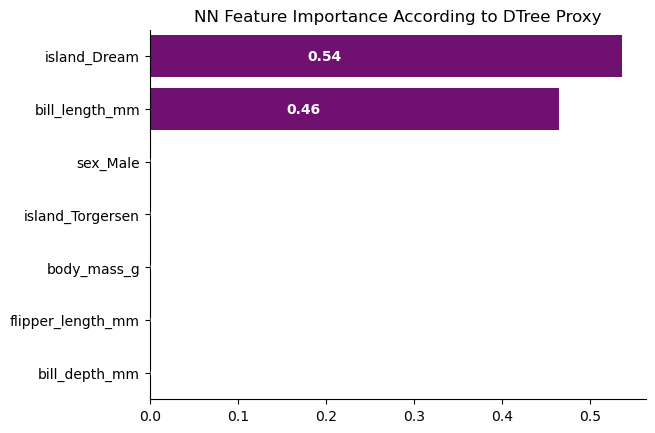

In [76]:
ax = sns.barplot(x=feature_importances[sort_idx], y=X_cols[sort_idx], color='purple', orient='h')
for index, val in enumerate(feature_importances[sort_idx]):
    ax.text(val/3, index, round(val, 2),color='white', weight='bold', va='center')
ax.set_title('NN Feature Importance According to DTree Proxy')
sns.despine(right=True)

**Fixing All But One Predictor**

We can alo try to see how a predictor affects the NN's output by fixing all the other to some "reasonable" values (e.g., mean, mode) and then only varying the predictor of interest.

Based on the results above, let's explore how `bill_length_mm` effects the NN's output.

**Construct 'Average' Observation**

In [77]:
# Review data types
X_design.dtypes

bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
island_Dream           uint8
island_Torgersen       uint8
sex_Male               uint8
dtype: object

In [78]:
# Take means for continous
means = X_scaled[:,:4].mean(axis=0)

# And modes for catgoricals
modes = pd.DataFrame(X_scaled[:,4:]).mode().values.reshape(-1)

In [79]:
# Shape Sanity Check
means.shape, modes.shape

((4,), (3,))

In [80]:
# Concatenate these two back together
avg_obs = np.concatenate([means, modes])

In [81]:
# And stick it back in a DataFrame
avg_obs = pd.DataFrame(avg_obs).transpose()
avg_obs.columns = X_design.columns
avg_obs

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_Male
0,1.662088e-16,-1.412775e-15,-8.310441e-16,4.155221e-17,-0.754193,-0.418638,0.965507


In [82]:
# Identify column in our array that corresponds to bill length
bill_col = np.argmax(X_design.columns == 'bill_length_mm')

# Find the min and max bill length stdevs in the data set
bill_min_std = np.min(X_scaled[:,bill_col])
bill_max_std = np.max(X_scaled[:, bill_col])

# Create 100 evenly spaced values within that range
bill_lengths = np.linspace(bill_min_std, bill_max_std, 100)

# Create 100 duplicates of the average observation
avg_df  = pd.concat([avg_obs]*bill_lengths.size,ignore_index=True)

# Set the bill length column to then linspace we just created
avg_df['bill_length_mm'] = bill_lengths

Notice now that all rows are identical except for `bill_length_mm` which slowly covers the entire range of values observed in the dataset.

In [83]:
avg_df.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_Male
0,-2.168526,-1.412775e-15,-8.310441e-16,4.155221e-17,-0.754193,-0.418638,0.965507
1,-2.117573,-1.412775e-15,-8.310441e-16,4.155221e-17,-0.754193,-0.418638,0.965507
2,-2.066619,-1.412775e-15,-8.310441e-16,4.155221e-17,-0.754193,-0.418638,0.965507
3,-2.015666,-1.412775e-15,-8.310441e-16,4.155221e-17,-0.754193,-0.418638,0.965507
4,-1.964712,-1.412775e-15,-8.310441e-16,4.155221e-17,-0.754193,-0.418638,0.965507


**Return Predictor to Original Scale**

When we visualize our results we'll want to do so back in the original scale for better interpretability.

Here we make use of our scaler object from way back when as it stores the means and standard deviations of the original, unscaled predictors.

In [84]:
# Recover the feature of interest on the original scale
bill_std = np.sqrt(scaler.var_[bill_col])
bill_mean = scaler.mean_[bill_col]
bill_lengths_original = (bill_std*bill_lengths)+bill_mean

We can sanity check out inverse transformation by confirming we recovereed the same min and max bill length from our very first DataFrame!

In [85]:
# Min Sanity Check
bill_lengths_original.min(), penguins.bill_length_mm.min()

(32.1, 32.1)

In [86]:
# Max Sanity Check
bill_lengths_original.max(), penguins.bill_length_mm.max()

(59.6, 59.6)

Now we are ready to plot an approximation of how `bill_length_mm` affects the NN's predictions.

4/4 [==============================] - 0s 887us/step


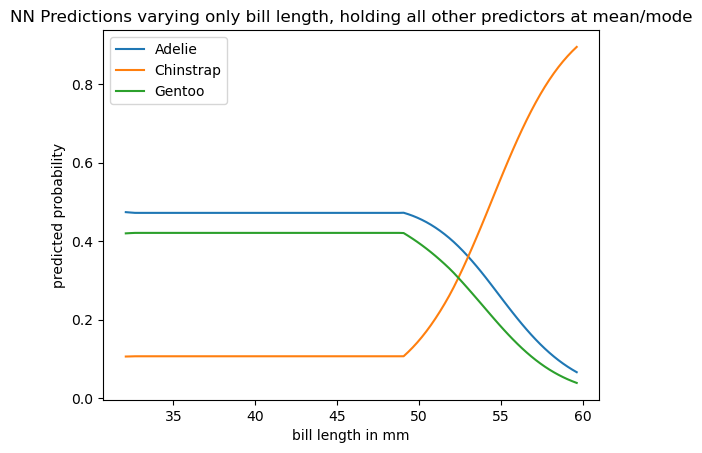

In [87]:
# Plot predicted class probabilities as a function of bill length (approx)
avg_pred = model.predict(avg_df)
fig, ax = plt.subplots()
for idx, species in enumerate(labenc.classes_): 
    plt.plot(bill_lengths_original, avg_pred[:,idx], label=species)
ax.set_ylabel('predicted probability')
ax.set_xlabel('bill length in mm')
ax.set_title('NN Predictions varying only bill length, holding all other predictors at mean/mode')

ax.legend();

If you know your penguins this should be too surprising. Gentoo penguins are the 3rd largest species after the emperor and king penguins (not represented in our dataset).

**Q:** Why is this only an *approximation* of how `bill_length_mm` affects the NN's predictions?

<div class='exercise'> <b>Bagging</div>

You'll be using bagging ("bootstrap aggregating") in your HW so let's take a minute to review the idea and see how it would work with a Kerass model.
    
The idea is to similuate multiple datasets by sampling our current one with replacement and fitting a model on this sample. The process is repeated multiple times until we have an *ensemble* of fitted models, all trained on slightly different datasets. 
    
We can then treat the ensemble as a singled 'bagged' model. When it is time to predict, each model in the ensemble makes its own predictions. These predictions can then be *aggregated* across models, for example, by taking the average or through majority voting.
    
We may also be interested in looking at the distribution of the predictions for a given observation as this may help us quanity our uncertainty in a way in which we could not with a single model's predictions (even if that model outputs a probability!)

In [88]:
# Set sup parameters for the bagging process
learning_rate=1e-1
epochs = 50
batch_size = 64
n_boot = 30
bagged_model = []
np.random.seed(109)

for n in range(n_boot):
    # Bootstrap
    boot_idx = np.random.choice(X_train.shape[0], size=X_train.shape[0], replace=True)
    X_train_boot = X_train[boot_idx]
    y_train_boot = y_train[boot_idx]

    # Build
    boot_model= build_NN(name=f'penguins_{n}',
                        input_shape=(X_train_boot.shape[1],),
                        hidden_dims=[8,16,32],
                        hidden_act='relu',
                        out_dim=3,
                        out_act='softmax')
    # Compile
    boot_model.compile(optimizer=SGD(learning_rate=learning_rate),
                       loss='categorical_crossentropy',
                       metrics=['acc', 'AUC'])

    # Fit
    boot_model.fit(X_train_boot,
                   y_train_boot,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=0)
    
    # Store bootstrapped model's probability predictions
    bagged_model.append(boot_model)

In [89]:
# Notice we can programatically recover the shape of a model's output layer
m = bagged_model[0]
out_dim = m.layers[-1].output_shape[-1]
print(out_dim)

3


In [90]:
def get_bagged_pred(bagged_model, X): 
    # Number of observations
    n_obs = X.shape[0]
    # Prediction dimensions (here, number of classes)
    pred_dim = bagged_model[0].layers[-1].output_shape[-1]
    # Number of models in the bagged ensemble
    n_models = len(bagged_model)
    # 3D tensor to store predictions from each bootstrapped model
    # n_observations x n_classes x n_models
    boot_preds = np.zeros((n_obs, pred_dim, n_models))
    # Store all predictions in the tensor
    for i, model in enumerate(bagged_model):
        boot_preds[:,:,i] = model.predict(X)
    # Average the predictions across models
    bag_pred = boot_preds.mean(axis=-1)
    return bag_pred, boot_preds

In [91]:
# Get aggregated and unaggregated ensemble predictions
bag_pred, boot_preds = get_bagged_pred(bagged_model, X_test)

6/6 [==============================] - 0s 664us/step


In [92]:
# Example of aggregated predictions
bag_pred[:3]

array([[0.02649804, 0.9601204 , 0.01338158],
       [0.04130083, 0.94791555, 0.01078361],
       [0.04985949, 0.93665924, 0.01348126]])

In [93]:
# Shape of unaggregated ensemble predictions tensor
boot_preds.shape

(171, 3, 30)

In [94]:
# Calculate bagged accuracy
bag_acc = sum(bag_pred.argmax(axis=-1) == y_test.argmax(axis=-1))/bag_pred.shape[0]
print('Bagged Acc:', bag_acc)

Bagged Acc: 0.9941520467836257


<div class="alert alert-info">
    <strong>🏋🏻‍♂️ Optional Take-home Challenges</strong></div>  

**Bagged NN Custom Python Class**

It would be nice if we could interact with our bagged model like any other keras model, passing Create a custom `Bagged_NN` class with its own `build`, `compile`, `fit`, `eval`, and `predict` methods!

**Use Bootstraped Predictions To Quantify Uncertainty**

In your HW you'll use bootstrapping to quantify uncertainty on predictions of a *binary* variable using Posterior Predictive Ratio (PPR). How might you do something similar with *categorical* bootstrapped predictions like we have here?

In [95]:
# Might something like entropy be useful?
from scipy.stats import entropy
entropy([0.25,0.25], base=2), entropy([0.8,0.2], base=2), entropy([1,0,0,0], base=2)

(1.0, 0.7219280948873623, 0.0)

<div class='exercise'> <b>An Image Classification Example</div>

The 2nd half of your HW asks you to classifying images. Let's try soemthing similar now using the famouse MNIST dataset of handwritten digits.\

We can load the dataset directly from Tensorflow/Keras! You can read more about TensorFlow's datasets [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets).

In [96]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [97]:
# Unique response variable values
set(y_test)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Each observation is an 28x28 pixel image.\
There are 60,000 training examples and 10,000 test images.\
The $y$ values corresponde to which of the digit the image represents, 0-9.

This is how each image is represented numerically.

In [98]:
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))
x_train[10]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  42, 118, 219, 166, 118, 118,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 103, 242, 254, 254, 254, 254, 254,  66,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  18, 232, 254, 254, 254, 254, 254, 238,  70,   0

The values represent pixel intensity and range from 0-255.\
We can use `plt.imshow` or `ax.imshow` to display it as an image.

This picture belongs to the class for number 3


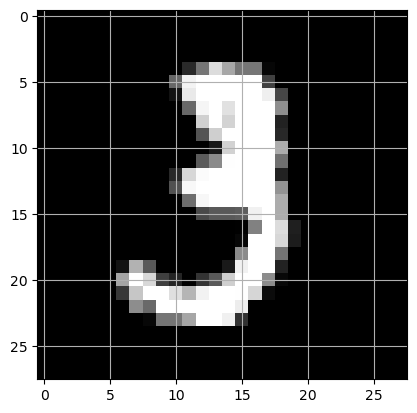

In [99]:
# Display and example observation as an image
print('This picture belongs to the class for number', y_train[10])
ax = plt.gca()
ax.grid('off')
ax.imshow(x_train[10], cmap='gray');

<div class='exercise'> <b>(Just a Little) Preprocessing</div>


**Flattening**

We don't know how to feed a 2D input into our neural networks (yet!). So we will simply flatted each image to a length 28x28 = 784 array.

In [100]:
# Flatten image data
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

# check if the shapes are ok
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


**Normalizing**

Let's confirm what we said about pixel values ranging from 0-255 and then normalize them to the range [0,1].

In [101]:
# checking the min and max of x_train and x_test
print(x_train.min(), x_train.max(), x_test.min(), x_test.max())

0 255 0 255


In [102]:
# Normalize
x_train = x_train/255
x_test = x_test/255

print(x_train.min(), x_train.max(), x_test.min(), x_test.max())

0.0 1.0 0.0 1.0


<div class='exercise'> <b>Build & Compile</div>

Here we use a little trick with the `'sparse_categorical_crossentropy'` loss. Basically, the saves us from having to turn our response variable into a categorical one! We can just leave them as integers. We'll also cheat a bit here and use the `Adam` optimizer. We'll learn more about this and other optimizers in the coming lectures and advanced section.
    
Notice too how a sequential Keras model can also be defined as a list passed to the `Sequential` constructor rather than by repeatedly using the `add` method. In future labs, we'll look at the *functional* Keras API, which is an alternative approach to sequential which is more flexible, allowing for more complex architectures.

In [103]:
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [104]:
# Build MNIST model
model_mnist = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape = (784,)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model_mnist.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

<div class='exercise'> <b>Fit</b></div>


In [105]:
# Fit the MNIST model
trained_mnist = model_mnist.fit(x_train,
                                y_train, 
                                epochs=6,
                                batch_size=128,
                                validation_data=(x_test, y_test))

Epoch 1/6
469/469 [==============================] - 1s 2ms/step - loss: 0.3614 - accuracy: 0.9006 - val_loss: 0.1848 - val_accuracy: 0.9456
Epoch 2/6
469/469 [==============================] - 1s 1ms/step - loss: 0.1598 - accuracy: 0.9545 - val_loss: 0.1366 - val_accuracy: 0.9615
Epoch 3/6
469/469 [==============================] - 1s 1ms/step - loss: 0.1155 - accuracy: 0.9670 - val_loss: 0.1097 - val_accuracy: 0.9689
Epoch 4/6
469/469 [==============================] - 1s 1ms/step - loss: 0.0898 - accuracy: 0.9739 - val_loss: 0.0967 - val_accuracy: 0.9715
Epoch 5/6
469/469 [==============================] - 1s 1ms/step - loss: 0.0728 - accuracy: 0.9796 - val_loss: 0.0890 - val_accuracy: 0.9745
Epoch 6/6
469/469 [==============================] - 1s 1ms/step - loss: 0.0618 - accuracy: 0.9823 - val_loss: 0.0836 - val_accuracy: 0.9747


In [106]:
# Helper function for plotting training history
def plot_accuracy_loss(model_history):
    plt.figure(figsize=[12,4])
    plt.subplot(1,2,1)
    plt.semilogx(model_history.history['accuracy'], label = 'train_acc', linewidth=4)
    plt.semilogx(model_history.history['val_accuracy'], label = 'val_acc', linewidth=4, alpha=.7)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.loglog(model_history.history['loss'], label = 'train_loss', linewidth=4)
    plt.loglog(model_history.history['val_loss'], label = 'val_loss', linewidth=4, alpha=.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()

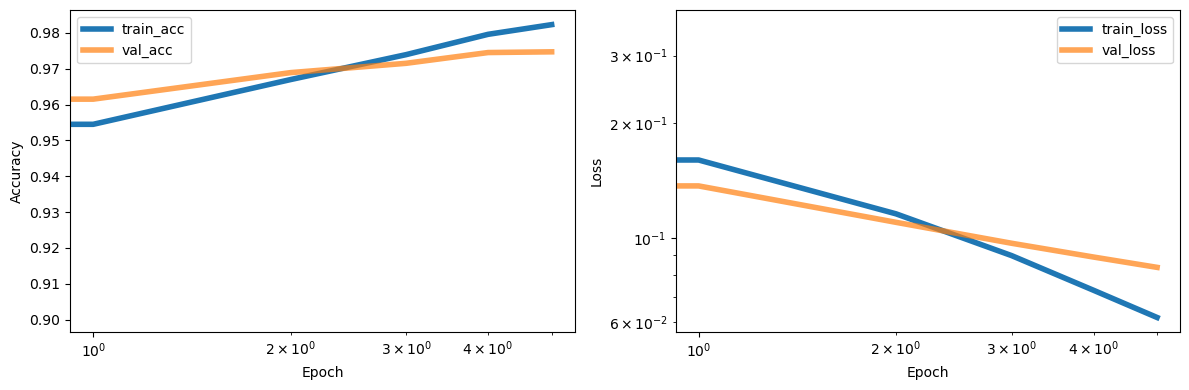

In [107]:
# Plot MNIST training history
plot_accuracy_loss(trained_mnist)

Not bad! But do see some overfitting as the validation accuracy starts to diverge from the training accuracy in later epochs. The same general trend can also be seen in the plot of the losses. In the next lecture we'll look at methods for dealing with overfitting in neural networks.

<div class='exercise'> <b>Visually Inspecting Model Performance</b></div>


A great benefit of working with image date is that you can often (but not always) simply look at an observation to see if your model's prediction make sense or not. Let's try that now!

In [108]:
# Make a single prediction and validate it
def example_NN_prediction(dataset = x_test, 
                          model_ = model_mnist):
    """
    This tests our MNist FFNN by examining a single prediction on the test set and 
    checking if it matches the real label.
    
    Arguments:
        n: if you select n then you will choose the nth test set
    """
    mnist_preds = model_mnist.predict(x_test)
    all_predictions = np.argmax(mnist_preds, axis = 1)
    
    n = np.random.choice(784)
    digit = x_test[n,:]
    actual_label = y_test[n]
    
    plt.imshow(digit.reshape(-1, 28))
    prediction_array = model_.predict(digit.reshape(1,-1))
    prediction = np.argmax(prediction_array)
    if prediction == y_test[n]:
        print("The Mnist model correctly predicted:", prediction)
    else:
        print("The true label was", actual_label)
        print("The Mnist model incorrectly predicted:", prediction)

####################################################        
# Make a many predictions and validate them
###################################################
def example_NN_predictions(model_,
                          dataset_ = x_test,
                          response_ = y_test,
                          get_incorrect = False):
    """
    This tests our MNist FFNN by examining 3 images and checking if our nueral network
    can correctly classify them.
    
    Arguments:
        model_ : the mnist model you want to check predictions for.
        get_incorrect (boolean): if True, the model will find 3 examples 
                        where the model made a mistake. Otherwise it just select randomly.
    """
    dataset  = dataset_.copy()
    response = response_.copy()
    
    # If get_incorrect is True, then get an example of incorrect predictions.
    # Otherwise get random predictions.
    if not get_incorrect:
        n = np.random.choice(dataset.shape[0], size = 3)
        digits = dataset[n,:]
        actual_label = response[n]
    else:
        # Determine where the model is making mistakes:
        mnist_preds = model_mnist.predict(dataset)
        all_predictions = np.argmax(mnist_preds, axis = 1)
        incorrect_index = all_predictions != response
        incorrect = x_test[incorrect_index, :]
        
        # Randomly select a mistake to show:
        n = np.random.choice(incorrect.shape[0], size = 3)
        digits  = incorrect[n,:]
        
        # determine the correct label
        labels = response[incorrect_index]
        actual_label = labels[n]
      
    #get the predictions and make the plot:
    fig, ax = plt.subplots(1,3, figsize = (12, 4))
    ax = ax.flatten()
    
    for i in range(3):
        #show the digit:
        digit = digits[i,:]
        ax[i].imshow(digit.reshape(28,-1)) #reshape the image to 28 by 28 for viewing
        
        # reshape the input correctly and get the prediction:
        prediction_array = model_.predict(digit.reshape(1,-1))
        prediction = np.argmax(prediction_array)
        
        #Properly label the prediction (correct vs incorrect):
        if prediction == actual_label[i]:
            ax[i].set_title("Correct Prediction: " + str(prediction))
        else:
            ax[i].set_title('Incorrect Prediction: {} (True label: {})'.format(
                prediction, actual_label[i]))
    plt.tight_layout()


1/1 [==============================] - 0s 12ms/step
The Mnist model correctly predicted: 1


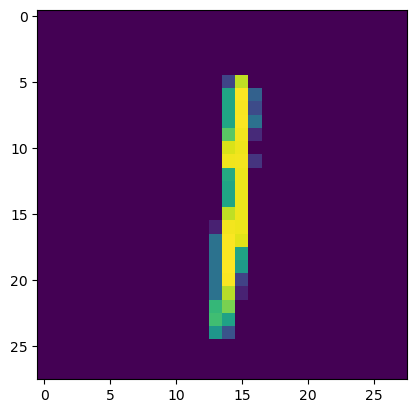

In [109]:
# Here's a random prediction example
example_NN_prediction()

1/1 [==============================] - 0s 12ms/step


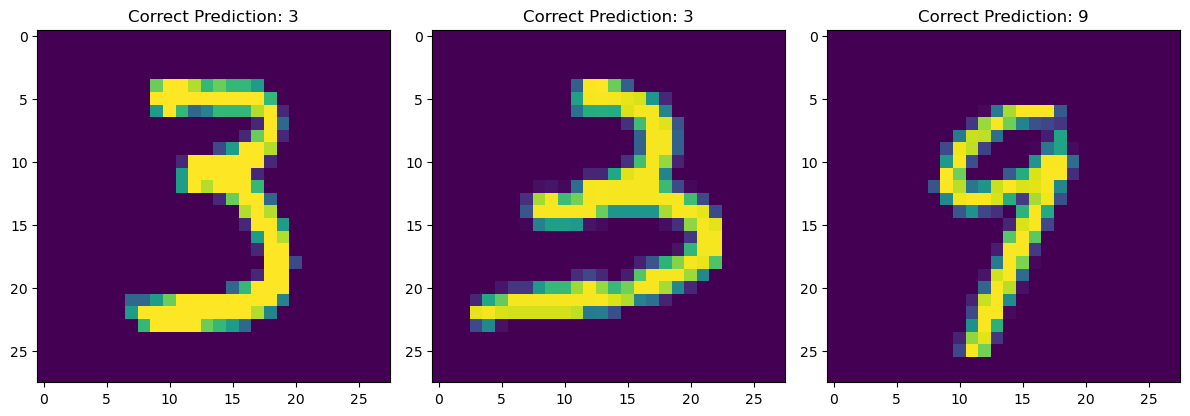

In [110]:
# Correct predictions
example_NN_predictions(model_ = model_mnist, get_incorrect = False)

Let's see some examples where the network makes the wrong prediction.

1/1 [==============================] - 0s 13ms/step


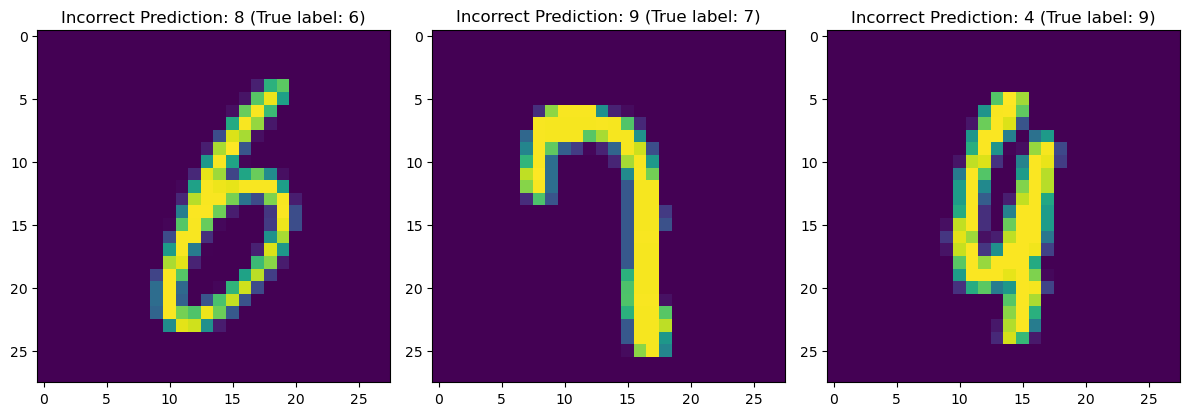

In [111]:
# Incorrect Predictions
example_NN_predictions(model_ = model_mnist, get_incorrect = True)

Oh my. That is some bad handwriting.